# A Typical Use Case

Often we want to check for stability over a range of initial conditions. Here we parallelize over a 2D grid of configurations as an example. 

In particular, let's take a 3-planet system, with the inner and outer planets circular, and we'll vary the middle planet's eccentricity along our y axis. Additionally, we make both planet pairs have the same period ratio, but vary the period ratio along our x axis.

A typical system will then look like this:

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb1490d1710>)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


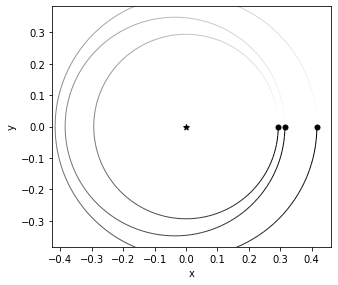

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from spock import FeatureClassifier
import rebound
%matplotlib inline

e=0.1
Pratio=1.3

sim = rebound.Simulation()
sim.add(m=1.)
sim.add(m=1.e-5, P=1, e=0)
sim.add(m=1.e-5, P=Pratio, e=e)
sim.add(m=1.e-5, P=Pratio**2, e=0)
rebound.OrbitPlot(sim)

To make our Period ratio vs eccentricity stability grid, we have to write a function that takes those two parameters, creates the initial conditions, and returns the stability probability. Pool.map expects a single tuple of parameters, so we unpack those:

In [2]:
def probstable(params):
    Pratio, e = params # unpack params
    sim = rebound.Simulation()
    sim.add(m=1.)
    sim.add(m=1.e-5, P=1, e=0)
    sim.add(m=1.e-5, P=Pratio, e=e)
    sim.add(m=1.e-5, P=Pratio**2, e=0)
    
    return model.predict_stable(sim)

Let's make a grid of 12 eccentricities from [0,1] and 40 period ratios from [1.5, 1.3]:

In [3]:
es = np.linspace(0, 0.1, 12)
Pratios = np.linspace(1.15, 1.3, 40)

Let's set up a Pool to make the predictions in parallel with the cores available on our machine. To run in parallel, each core needs to have a separate `FeatureClassifier` instance, so we pass an initializer:

In [4]:
from multiprocessing import Pool        

def init_process():
    global model
    model = FeatureClassifier()

pool = Pool(initializer=init_process)

Perhaps the most valuable contribution of this notebook is the below pair of functions to generate a centered 2D grid of values:

In [5]:
def get_pool_params(xlist, ylist):
    params = []
    for y in ylist:
        for x in xlist:
            params.append((x, y))
    return params
            
def get_centered_grid(xlist, ylist, poolresults):  
    # assumes uniformly spaced values in x and y (can have different lengths)
    dx = xlist[1]-xlist[0]
    dy = ylist[1]-ylist[0]

    xgrid = [x - dx/2 for x in xlist] + [xlist[-1]+dx/2]
    ygrid = [y - dy/2 for y in ylist] + [ylist[-1]+dy/2]

    X, Y = np.meshgrid(xgrid, ygrid)
    Z = np.array(poolresults).reshape(len(ylist),len(xlist))

    return X,Y,Z

`get_pool_params` takes the lists of values you want along the x and y axes, and returns a 1-D list of (x,y) pairs as expected by Pool.map:

In [6]:
%%time
params = get_pool_params(Pratios, es)
results = pool.map(probstable, params)

CPU times: user 19.3 ms, sys: 5.96 ms, total: 25.3 ms
Wall time: 19.9 s


`get_centered_grid` then takes the same x and y lists, together with the output of Pool.map and returns the X,Y,Z values for pcolormesh:

Text(0, 0.5, 'Middle Planet Eccentricity')

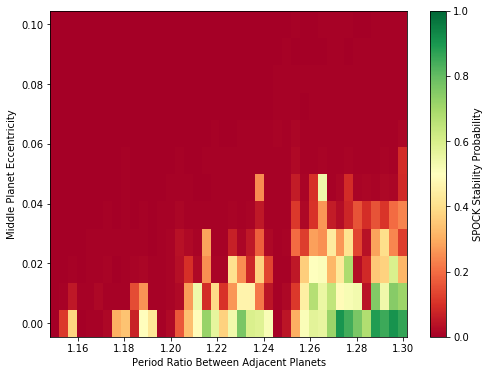

In [7]:
fig, ax = plt.subplots(figsize=(8,6))

X,Y,Z = get_centered_grid(Pratios, es, results)
im = ax.pcolormesh(X, Y, Z, vmin=0, vmax=1, cmap="RdYlGn")

cb = plt.colorbar(im, ax=ax)
cb.set_label("SPOCK Stability Probability")
ax.set_xlabel("Period Ratio Between Adjacent Planets")
ax.set_ylabel("Middle Planet Eccentricity")

This takes about 20s on my Macbook Pro, but would take ~1000 hours with direct N-body!

We see that, as expected, things are more stable at wider period ratios and lower eccentricities. But superimposed on these trends we also see the de-stabilizing effects of mean-motion resonances at integer period ratios (e.g., the 5:4 at 1.25). 

Note that this is because we've ignored all the pericenter orientations and phases (which default to 0 in REBOUND when we don't set them explicitly), so we never actually place our systems IN resonance. In this case resonances are strongly DEstabilizing. If we instead slowly migrated systems into resonance (see, e.g., https://github.com/dtamayo/trappist for example code), we should see these stable islands.